In [1]:
# SimPy Simulation of a food-stall.
#
# Author: Neha Karanjkar 4 August 2019
#
# System Description:
#
#
# There is a food stall that operates everyday for 6 hours (8am to 2pm).
# Usually there is a rush between 8am-9am and 1pm-2pm.
# During the rush hours, customers arrive with inter-arrival times
# ranging from 1min-2min (uniformly distributed), and in
# non-rush-hours, the inter-arrival times range from 5min-10min.
#
# The stall has seating space for 6 persons. Whenever a customer arrives,
# if all seats are occupied, the customer leaves without making an order.
# If at-least one seat is empty, the customer orders a plate of food,
# occupies a seat, and leaves after finishing, typically taking between
# 15min-30min for eating.

# Assume that each customer served generates a profit of Rs 100 for the stall.


import simpy
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:

# --------------------------------------------------
# Model parameters:
# --------------------------------------------------
WORKING_HOURS = 6
# We assume that 1 unit of time in SimPy corresponds to 1 minute.

# Inter-arrival times:
# Rush hour -> 1-2 min , non-rush hour -> 5-10 min
RUSH_HOUR_T_MIN = 1
RUSH_HOUR_T_MAX = 2

NON_RUSH_HOUR_T_MIN = 7
NON_RUSH_HOUR_T_MAX = 20


# Time for which a customer occupies a seat
# Time -> 15-30 min
SEAT_OCCUPANCY_TIME_MIN = 15
SEAT_OCCUPANCY_TIME_MAX = 30

TOTAL_NUM_SEATS = 15
PROFIT_PER_CUSTOMER_SERVED = 100


# --------------------------------------------------
# some counters:
# --------------------------------------------------
num_customers = 0
num_customers_served = 0
num_customers_backed_out = 0

enter_or_back_out = []
times_enter_or_back_out = []

#  A process that models the arrival of customers
def customer_arrival(env, seats):
    ''' A process that models the arrival of customers'''
    count = 0
    while True:
        count += 1

        # create a new customer
        c = customer(env, count, seats)
        env.process(c)

        # wait for some time before generating the next customer.
        if (
            env.now < 1 * 60 or env.now > 5 * 60
        ):  # If it is between 8am-9am or after 1pm ie Rush hour
            inter_arrival_time = random.uniform(
                RUSH_HOUR_T_MIN, RUSH_HOUR_T_MAX)

        else:  # If it is after 10 am ie non-Rush hour
            inter_arrival_time = random.uniform(
                NON_RUSH_HOUR_T_MIN, NON_RUSH_HOUR_T_MAX
            )

        yield env.timeout(inter_arrival_time)


#  A process that models the behavior of each customer
def customer(env, name, seats):
    ''' A process that models the behavior of each customer - parameters:
        env: SimPy environment
        name: name of the customer
        seats: SimPy resource
    '''
    global num_customers, num_customers_served, num_customers_backed_out

    # If there's a vacant seat...
    if seats.count < seats.capacity:
        enter_or_back_out.append(1)
        times_enter_or_back_out.append(env.now)
        print(
            "SIM_TIME=%5.2f Customer %d arrived. " % (env.now, name),
            "%d of %d seats are occupied. " % (seats.count, seats.capacity),
            "Customer occupied one seat.",
        )

        # occupy a seat for some time
        my_seat = seats.request()
        yield my_seat
        occupancy_time = random.uniform(
            SEAT_OCCUPANCY_TIME_MIN, SEAT_OCCUPANCY_TIME_MAX
        )
        yield env.timeout(occupancy_time)
        # release the seat
        seats.release(my_seat)

        print("SIM_TIME=%5.2f Customer %d left the stall after eating. " %
              (env.now, name))
        num_customers += 1
        num_customers_served += 1
    else:
        # leave the stall.
        enter_or_back_out.append(0)
        times_enter_or_back_out.append(env.now)
        print(
            "SIM_TIME=%5.2f Customer %d arrived. " % (env.now, name),
            "%d of %d seats are occupied. " % (seats.count, seats.capacity),
            "Customer LEFT without ordering.",
        )
        num_customers += 1
        num_customers_backed_out += 1




In [14]:
# Create a SimPy environment and populate it with processes and resources
env = simpy.Environment()  # create an environment
# create a resource to model seats
seats = simpy.Resource(env, capacity=TOTAL_NUM_SEATS)
# create a process to model customer arrivals.
env.process(customer_arrival(env, seats))

# Start the simulation
env.run(until=WORKING_HOURS * 60)  # simulate for WORKING_HOURS*60 minutes


# Print results
print("\n\n Results ( for TOTAL_NUM_SEATS =", TOTAL_NUM_SEATS, "):")
print("Total number of customers that arrived = ", num_customers)
print(
    "Total number of customers that were served = %d (%4.2f%%)"
    % (num_customers_served, num_customers_served / num_customers * 100)
)
print(
    "Total number of customers that backed out = %d (%4.2f%%)"
    % (num_customers_backed_out, num_customers_backed_out / num_customers * 100)
)
print(
    "Total profit generated for the day = Rs %d"
    % (num_customers_served * PROFIT_PER_CUSTOMER_SERVED)
)


SIM_TIME= 0.00 Customer 1 arrived.  0 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 1.55 Customer 2 arrived.  1 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 2.61 Customer 3 arrived.  2 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 3.99 Customer 4 arrived.  3 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 5.41 Customer 5 arrived.  4 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 7.18 Customer 6 arrived.  5 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME= 9.07 Customer 7 arrived.  6 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME=10.44 Customer 8 arrived.  7 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME=11.62 Customer 9 arrived.  8 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME=12.99 Customer 10 arrived.  9 of 15 seats are occupied.  Customer occupied one seat.
SIM_TIME=14.08 Customer 11 arrived.  10 of 15 seats are occupied.  Cu

<AxesSubplot:>

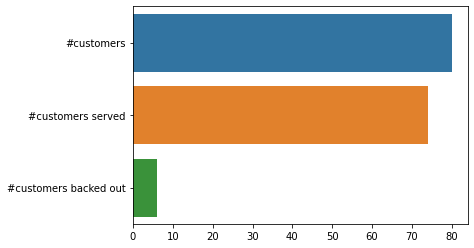

In [15]:

titles = ['#customers', '#customers served','#customers backed out']
values = [num_customers, num_customers_served, num_customers_backed_out]

# plot values

sns.barplot(x=values, y=titles)

Text(0.5, 1.0, 'Customers Enter or Back Out on arrival and exit times')

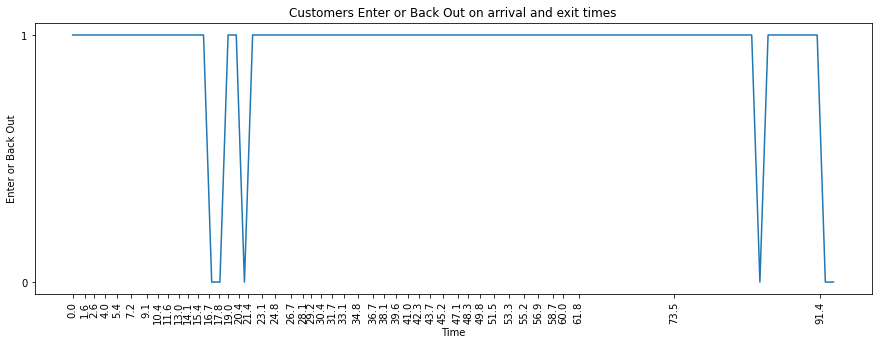

In [34]:
# Discrete chart -> 1 represents a customer that was served , 0 represents a customer that backed out
plt.figure(figsize=(15, 5))
plt.yticks([0,1])
plt.xticks(times_enter_or_back_out,rotation=90)
plt.xlabel('Time')
plt.ylabel('Enter or Back Out')
plt.plot(enter_or_back_out)
plt.title('Customers Enter or Back Out on arrival and exit times')

In [1]:
print(int(2034.5))

2034
